# Example: Neural Networks with partitions

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Flux: Chain, Dense, relu, mse, train!, params, ADAM
using Random
using Gogeta
using Plots
using Gurobi
using JuMP
using LaTeXStrings
using CSV
using DataFrames
using StatsBase
using LinearAlgebra
using StatsPlots
using QuasiMonteCarlo

## Introduction

In this Jupyter notebook, we present a different way how to formulate a neural network as a MIP problem based on the follwing paper [[1]](https://arxiv.org/abs/2102.04373). The idea is that variables are split into $N$ non-overlapping sets – partitions. We are interested in the smallest number of partitions $N$ such that the bounds for the variables are as tight as possible.

At first, we will introduce you to the function itself and its parameters. Then we will its computation performance on an easy function. In the end, we will try applying this partition-based formulation on the real dataset.

Suppose we have next function to learn with NN:
$$f(x_1, x_2,x_3,x_4) = (x_1+x_2)^2/5 + (x_3+x_4)^2/10 + +x_3$$
where $x_1\in[0, 1]$, $x_2\in[-0.5, 0.5]$, $x_3\in[1, 2]$, $x_4\in[0, 1]$


In [2]:
function f(x)
    return (x[1]+x[2])^2/5+(x[3]-x[4])^2/10 - 5*x[3]*x[1]+x[2]*x[4]/3
end

f (generic function with 1 method)

In [3]:
# this function will allow to generate random floar number in a range
g = (a, b) -> b + (a - b) * rand()

#1 (generic function with 1 method)

### Generate artificial dataset

In [4]:
dataset = zeros(10000, 5)
counter = 1

for i = 1:10000
    x = [g(0,1), g(-0.5, 0.5), g(1, 2), g(0,1)]
    dataset[i, :] = push!(x, f(x))
end

X = dataset[:, 1:4];
y = dataset[:, 5];

sample = randsubseq(1:size(dataset, 1), 0.7)
X_train = Array{Float32}(X[sample, :])';
y_train = Array{Float32}(y[sample, :])';

notsample = [i for i in 1:size(dataset,1) if isempty(searchsorted(sample, i))]
X_test= Array{Float32}(X[notsample, :])';
y_test = Array{Float32}(y[notsample, :])';

data_train = Flux.Data.DataLoader((X_train, y_train), batchsize=64);

### Train and test NN

epoch #10, training loss: 0.03729734942317009, test loss: 0.03557046875357628
epoch #20, training loss: 0.012075068429112434, test loss: 0.011828446760773659
epoch #30, training loss: 0.0040692831389606, test loss: 0.004003108944743872
epoch #40, training loss: 0.0017712132539600134, test loss: 0.0017480013193562627
epoch #50, training loss: 0.001091985497623682, test loss: 0.0011076618684455752
epoch #60, training loss: 0.000968168315012008, test loss: 0.001035524532198906
epoch #70, training loss: 0.0006355253281071782, test loss: 0.0006727464497089386
epoch #80, training loss: 0.0006136722513474524, test loss: 0.000625145505182445
epoch #90, training loss: 0.00040317149250768125, test loss: 0.0004234162624925375
epoch #100, training loss: 0.0003640339709818363, test loss: 0.0003842053993139416
epoch #110, training loss: 0.00034081199555657804, test loss: 0.00035549706080928445
epoch #120, training loss: 0.00032402947545051575, test loss: 0.0003365052107255906
epoch #130, training lo

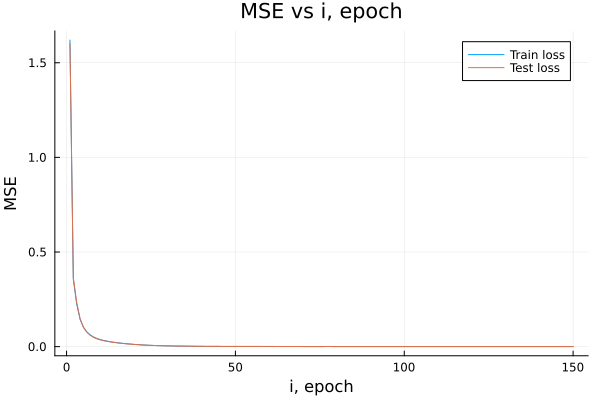

In [5]:
model = Chain(
    Dense(size(X)[2], 128, relu),
    Dense(128, 1),
)

loss(x, y) = Flux.mse(model(x), y)
opt = AdaBelief()
epochs = 150
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (X_batch, y_batch) in data_train
        train!(loss, params(model), [(X_batch, y_batch)], opt);
    end
    push!(train_losses, loss(X_train, y_train));
    push!(test_losses, loss(X_test, y_test))
    if epoch%10 == 0
        println("epoch #", epoch, ", training loss: ", train_losses[end], ", test loss: ", test_losses[end])
    end
end

plot(train_losses, xlabel="i, epoch", ylabel="MSE", title="MSE vs i, epoch", label="Train loss")
plot!(test_losses, label="Test loss")

### Formulation of NN as a MIP using partiiton-based formulation

Once we have trained neural network, we need to innitialize empty `JuMp` model with `Gurobi`.


In [7]:
jump_model = Model(Gurobi.Optimizer);
set_silent(jump_model) #disables output of the optimazer
set_attribute(jump_model, "TimeLimit", 10) #sets the time limit to be 10 seconds

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


The formulation of NN is done with function `NN_formulate_Psplit!`. It has next set of input parameters:

    - `jump_model`: The constraints and variables will be saved to this optimization model.
    - `NN_model`: Neural network model to be formulated.
    - `P`: The number of splits
    - `U_in`: Upper bounds for the input variables.
    - `L_in`: Lower bounds for the input variables.
    - `strategy` (optional): the way partitioning is done, possible options include: "equalsize", "equalrange", "random". Default is "equalsize".
    - `silent`(optional): Controls console ouput.
    - `bound_tightening` (optional): possible options include: "standart", "precomputed", and "fast" (default)

    There are some restrictions about the strategies for partitioning and architecture of the NN. NN can only have ReLU as activation function and no activation function in the last layer. With "equalrange" partition strategy, number of partitions should be greater or equal than 3. 

Formulation requires us to define lower and upper bounds for the input variables, we can find it using training set.

In [8]:
init_L, init_U = minimum.(eachrow(X_train)), maximum.(eachrow(X_train));

In [9]:
P = 4
println("Time to formulate NN as a JuMP model:")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

Time to formulate NN as a JuMP model:
  3.136064 seconds (8.02 M allocations: 541.999 MiB, 4.62% gc time, 99.57% compilation time: 2% of which was recompilation)


Since we are interested in minimizing or maximizing the function $f$, we need to either minimize or maximize the output neuron. We have already explained how to get it in the previous Jupyter notebook related to neural networks.

In [10]:
# we are interested in the output neuron
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]

x[2,1]

Just for sake of criousity, lets look what are the minimum and maximum values of $f$ in the generated dataset

In [11]:
println("Minimum value in the dataset is ", minimum(dataset[:,5]))
println("x = ", dataset[argmin(dataset[:, 5]), 1:4])
println("Maximum value in the dataset is ", maximum(dataset[:,5]))
println("x = ", dataset[argmax(dataset[:, 5]), 1:4])

Minimum value in the dataset is -9.504499819808986
x = [0.9934874372825441, -0.22295474186782505, 1.9490355142265234, 0.8471124063908011]
Maximum value in the dataset is 0.35031708009958784
x = [0.0009361987041772712, -0.01654044599355675, 1.9916368789695331, 0.09398203891305579]


In [12]:
@objective(jump_model, Min, output_neuron)
println("Time to minimize model:")
@time optimize!(jump_model)

println("The model found next solution:\n", value.(jump_model[:x][0, :]))
println("With objective function: ", objective_value(jump_model) )
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
println("NN output: ", model(solution)[1], "\nTrue value of function: ", f(solution) )

Time to minimize model:
  0.739479 seconds (1.94 M allocations: 129.212 MiB, 2.11% gc time, 90.95% compilation time: 10% of which was recompilation)
The model found next solution:
  [1]  =  0.999628
  [2]  =  -0.499773
  [3]  =  1.99954
  [4]  =  0.999982
With objective function: -9.879981359224544
NN output: -9.879981
True value of function: -10.0106945


In [13]:
@objective(jump_model, Max, output_neuron)
println("Time to maximize model:")
@time optimize!(jump_model)

println("The model found next solution:\n", value.(jump_model[:x][0, :]))
println("With objective function: ", objective_value(jump_model) )
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
println("NN output: ", model(solution)[1], " \nTrue value of function: ", f(solution) )

Time to maximize model:
  0.124873 seconds (667 allocations: 20.797 KiB)
The model found next solution:
  [1]  =  0.000257558
  [2]  =  0.49971
  [3]  =  1.99954
  [4]  =  0.000284697
With objective function: 0.3835120365162935
NN output: 0.38351208 
True value of function: 0.44716907


Approximation of the function found by the neural network is not perfect since the value produced by NN and true values are different, but the solutions found by partition based formulation are better than directly taking from the dataset. 

## Testing out different input parameters for partition based formulation

### Different number of partitions

Increasing the number of partitions, increases the size of the JuMP model.

In [14]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 2, init_U, init_L);
jump_model

  0.039712 seconds (103.44 k allocations: 6.516 MiB, 82.83% compilation time)


A JuMP Model
Maximization problem with:
Variables: 517
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1285 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

In [15]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 3, init_U, init_L);
jump_model

  0.006078 seconds (84.16 k allocations: 5.049 MiB)


A JuMP Model
Maximization problem with:
Variables: 645
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1797 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

In [16]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 4, init_U, init_L);
jump_model

  0.007464 seconds (103.06 k allocations: 6.320 MiB)


A JuMP Model
Maximization problem with:
Variables: 773
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 2309 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

Make sure that the number of partitions is reasonable.

In [17]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 5, init_U, init_L, silent = false);

Creating JuMP model...

LAYER 1

LAYER 2
  0.016310 seconds (110.61 k allocations: 6.745 MiB, 16.48% compilation time)


Too many partitions will result in generation of empty sets. You can find out if there are any by putting `silent=true`. The formuation described in the paper implies that number of partitions should be way less than number of variables. In our implementation, if there are any emprty partitions, they are dropped.

### Different `bound-tightening`

By default the bounds are calculated with `fast` bound-tightening which results in producins loose bounds. You can choose to switch to `standard` bound-tightening – in this case the bounds will be tighter and optimization of the model  will be faster, but formulation of the model will be much slower. Sometimise `fast` bounds are good enough and using `standard` bound-tightening is infeasible.

In [18]:
P = 4

println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U_fast, bounds_L_fast = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);
@objective(jump_model, Min, output_neuron)
println("Time to optimize model:")
@time optimize!(jump_model)

println("\nTime to formulate with 'standard' bounds, 'equalsize' strategy ")
@time bounds_U_st, bounds_L_st = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening="standard");
@objective(jump_model, Min, output_neuron)
println("Time to optimize model:")
@time optimize!(jump_model)

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.024936 seconds (103.06 k allocations: 6.320 MiB, 66.18% gc time)
Time to optimize model:
  0.061054 seconds (25.83 k allocations: 1.999 MiB)

Time to formulate with 'standard' bounds, 'equalsize' strategy 
 22.828604 seconds (2.07 M allocations: 116.352 MiB, 0.07% gc time, 2.85% compilation time: 1% of which was recompilation)
Time to optimize model:
  0.049773 seconds (1.25 k allocations: 39.141 KiB)


If you have already computed the bounds, you can use "precomputed" bound-tightening. Just specify the input `U_bounds` and `L_bounds`. Just make sure that `U_bounds` and `L_bounds` are of the right size and reasonable. Nothing is returned.

In [19]:
@time NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, U_bounds=bounds_U_st, L_bounds=bounds_L_st, bound_tightening="precomputed")

  0.249317 seconds (270.97 k allocations: 18.372 MiB, 6.72% gc time, 96.17% compilation time)


### Different partition strategies

Authors of the paper insist that elements inside of the partitions should be similar, that is why the suggest using `equalsize` and `equalrange` parttion strategies. Both of them sort variables at first and then `equalsize` strategy split elements to sets of equal sizes in order. In return `equalrange` strategy makes sure that ranges of all partitions are approximately the same.

The authors also introduce `random` and `snake` partition strategies that should produce much poorer results. They are also present in this implementation.

To understand how different partition strategies work, user may wish to play with `Psplits()` function. It has next set of input parameters:

    - `w`: Vector with weights of variables
    - `P`: Number of partitions to generate
    - `strategy`: Partition strategy. Possible options: `equalsize`, `equalrange`, `random`, `snake`

`Psplits()` returns indexes of the partitioned weights

In [20]:
w = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

println("Partitions generated with 'equalsize':\n", Psplits(w, 4, "equalsize"))
println("Partitions generated with 'equalrange':\n",Psplits(w, 4, "equalrange"))
println("Partitions generated with 'random':\n",Psplits(w, 4, "random"))
println("Partitions generated with 'snake':\n",Psplits(w, 4, "snake"))

Partitions generated with 'equalsize':
[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
Partitions generated with 'equalrange':
[[1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11], [12]]
Partitions generated with 'random':
[[1, 7], [3, 6, 9, 10, 12], [5, 11], [2, 4, 8]]
Partitions generated with 'snake':
[[1, 8, 9], [2, 7, 10], [3, 6, 11], [4, 5, 12]]


In [21]:
P = 3

println("Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalsize'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "equalsize");
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalrange'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "equalrange" );
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'random'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "random");
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'snake'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "snake");
@time optimize!(jump_model)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalsize'
 22.008855 seconds (758.55 k allocations: 29.246 MiB, 0.02% compilation time)
  0.003855 seconds (36 allocations: 1.078 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalrange'
 15.406451 seconds (723.55 k allocations: 28.144 MiB, 0.14% gc time)
  0.003730 seconds (36 allocations: 1.078 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'random'
 12.098541 seconds (705.79 k allocations: 27.981 MiB, 0.08% compilation time)
  0.006200 seconds (38 allocations: 1.141 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'snake'
 15.703490 seconds (724.09 k allocations: 28.143 MiB, 0.05% gc time)
  0.006177 seconds (37 allocations: 1.109 KiB)


## Real dataset

For this example, we are going to use "Life Expectancy" dataset from the kaggle platform [[2]](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who?resource=download). The dataset for this example was preprocessed in advance: we left only data for 2015 year, dropped column country, country status was encoded as 1 ("Developed") or 0 ("Developing"), "Alcohol","Total expenditure", "Population" were dropped since they have too many unknown values, some other features were dropped due to imbalance.

In [22]:
data = CSV.read("datasets/LifeExpectanceData.csv", DataFrame)
first(data, 5)

Row,Status,Life expectancy,Adult Mortality,Hepatitis B,BMI,Polio,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,65.0,263.0,65.0,19.1,6.0,65.0,17.2,17.3,0.479,10.1
2,0.0,59.9,271.0,62.0,18.6,58.0,62.0,17.5,17.5,0.476,10.0
3,0.0,59.9,268.0,64.0,18.1,62.0,64.0,17.7,17.7,0.47,9.9
4,0.0,59.5,272.0,67.0,17.6,67.0,67.0,17.9,18.0,0.463,9.8
5,0.0,59.2,275.0,68.0,17.2,68.0,68.0,18.2,18.2,0.454,9.5


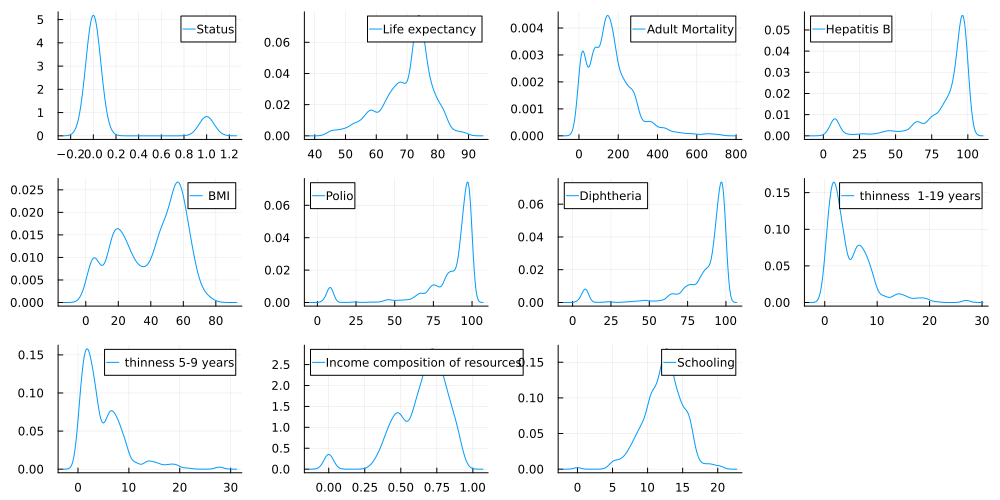

In [23]:
plot_array = [] 

for i = 1:11
    push!(plot_array, density(data[:, i], label = names(data)[i]))

end

# Combine plots into a single plot
plot(plot_array...,  legend=true)
plot!(size=(1000,500))

The target column of the dataset is "Life Expectancy" – we are interested in which case life expectatncy is minimumized or maximumized. The features are normalized with `ZScoreTransform` (now the mean is 0 and the standard deviation is 1).

In [24]:
y = data[!, Symbol("Life expectancy ")];
X = data[:, Not(Symbol("Life expectancy "), Symbol("Status"))];
dt = fit(ZScoreTransform, Matrix(X), dims=1);
X = StatsBase.transform(dt, Matrix(X));
X = [data[:, Symbol("Status")] X];

Now, we need to split our dataset into training and testing datasets (80% for training)

In [38]:
sample = randsubseq(1:size(data, 1), 0.8)
X_train = transpose(Array{Float32}(X[sample, :]));
y_train = transpose(Array{Float32}(y[sample, :]));

notsample = [i for i in 1:size(data,1) if isempty(searchsorted(sample, i))]
X_test= transpose(Array{Float32}(X[notsample, :]));
y_test = transpose(Array{Float32}(y[notsample, :]));

data_train = Flux.Data.DataLoader((X_train, y_train), batchsize=16);

## Initialize neural network

Generate some arbitrary neural network, loss function and optimizer of your choice.

In [39]:
model = Chain(
    Dense(size(X)[2], 256, relu),
    Dense(256, size(X)[2], relu),
    Dense(size(X)[2], 1)
)

loss(x, y) = Flux.huber_loss(model(x), y)
opt = AdamW()

Flux.Optimise.Optimiser(Any[Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

## Training the neural network

epoch #1, training loss: 52.008827209472656, test loss: 51.57008743286133
epoch #2, training loss: 15.175454139709473, test loss: 15.754034996032715
epoch #3, training loss: 9.425439834594727, test loss: 9.299555778503418
epoch #4, training loss: 6.873861789703369, test loss: 6.409117698669434
epoch #5, training loss: 5.498692035675049, test loss: 5.104722499847412
epoch #6, training loss: 4.572873115539551, test loss: 4.2724714279174805
epoch #7, training loss: 3.8829896450042725, test loss: 3.6850314140319824
epoch #8, training loss: 3.3272156715393066, test loss: 3.1975369453430176
epoch #9, training loss: 2.9165725708007812, test loss: 2.8202707767486572
epoch #10, training loss: 2.6504273414611816, test loss: 2.5837535858154297
epoch #11, training loss: 2.4940710067749023, test loss: 2.4551289081573486
epoch #12, training loss: 2.343421459197998, test loss: 2.3234095573425293
epoch #13, training loss: 2.2271077632904053, test loss: 2.2249555587768555
epoch #14, training loss: 2.15

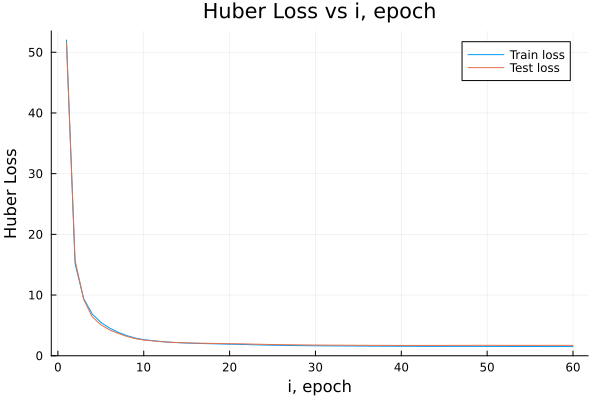

In [40]:
epochs = 60
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (X_batch, y_batch) in data_train
        train!(loss, params(model), [(X_batch, y_batch)], opt);
    end
    push!(train_losses, loss(X_train, y_train));
    push!(test_losses, loss(X_test, y_test))
    println("epoch #", epoch, ", training loss: ", train_losses[end], ", test loss: ", test_losses[end])
end

plot(train_losses, xlabel="i, epoch", ylabel="Huber Loss", title="Huber Loss vs i, epoch", label="Train loss")
plot!(test_losses, label="Test loss")

The loss function failed to converge to 0 for both training and testing sets. It seems that either there is not enough data to learn the function or NN is not complex enough to generalize at this dataset. But just for the sake of experiment, we can see how partition-based formulation can be used to minimize or maximize the function. So, suppose that the NN is good enough to draw conclusions (better combination of learning parameters + preprocessing can be done by user). 

Suppose, we want to get a formulation of NN with 3 partitions, fast bound tightening and `equalrange` as a strategy for partition.

***Note:*** Don't forget about lower and upper bounds bounds for the input variables, which can be found by taking minimum and maximum values from the datasey for each variable.

In [41]:
init_U = maximum.(eachcol(X_train'));
init_L = minimum.(eachcol(X_train'));

In [42]:
# names of features for future printing of the soultion
feat_list = filter(x -> x!="Life expectancy ", names(data));

Now, we want to know which input parameters produce the longest life expectancy:

In [43]:
# number of parttions set to 4 (recommended to experiment with it)
P = 4
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

# we are interested in the output neuron, which is Life expectancy
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]
@objective(jump_model, Max, output_neuron)

println("Time to maximize model:")
@time optimize!(jump_model)
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
# remember to reconstruct features (get values before z score transformation)
df = DataFrame([[round(x) == 1 ? "Developed" : "Developing" for x in solution[1]] StatsBase.reconstruct(dt, solution[2:end]')],  feat_list)
println("optimal solution:")
println(df)
println("Maximum life expectancy: ", objective_value(jump_model))

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.028142 seconds (355.80 k allocations: 17.752 MiB)
Time to maximize model:
 10.010312 seconds (60.64 k allocations: 5.121 MiB)
optimal solution:
1×10 DataFrame
 Row │ Status      Adult Mortality  Hepatitis B   BMI     Polio    Diphtheria    thinness  1-19 years   thinness 5-9 years  Income composition of resources  Schooling 
     │ Any         Any              Any          Any      Any      Any          Any                    Any                  Any                              Any       
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Developing  149.969          83.0359      44.1587  91.1021  99.0         6.24528                0.0999999            0.740082                         13.7943
Maximum life expectancy: 74.74510448140086


Now, lets find minimum life expectancy

In [44]:
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]
@objective(jump_model, Min, output_neuron)


println("Time to minimize model:")
@time optimize!(jump_model)
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
df = DataFrame([[round(x) == 1 ? "Developed" : "Developing" for x in solution[1]] StatsBase.reconstruct(dt, solution[2:end]')],  feat_list)
println("Optimal solution:")
println(df)
println("Minimum life expectancy: ", objective_value(jump_model))

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.033504 seconds (355.80 k allocations: 17.752 MiB, 26.43% gc time)
Time to minimize model:
  2.186440 seconds (57.54 k allocations: 5.026 MiB)
Optimal solution:
1×10 DataFrame
 Row │ Status     Adult Mortality  Hepatitis B   BMI   Polio    Diphtheria    thinness  1-19 years   thinness 5-9 years  Income composition of resources  Schooling 
     │ Any        Any              Any          Any    Any      Any          Any                    Any                  Any                              Any       
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Developed  723.0            58.8287      1.4    51.7998  77.8545      16.9908                18.0138              0.130622                         7.19943
Minimum life expectancy: 35.42485758859324


The optimization results imply that life expectancy would be higher in case of low adult mortality, high imunization coverage (Hepatitis B, Polio, Diphteria), longer school, highier income composition of resources, which sounds reasonable. Thinness and low BMI are implied to lead to smaller life expectancy. But this is just an example how partition based formulation can be applied in practice.

In [50]:
data[argmax(data[:, 2]), :]

Row,Status,Life expectancy,Adult Mortality,Hepatitis B,BMI,Polio,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
220,1.0,89.0,76.0,98.0,63.4,99.0,99.0,1.0,1.0,0.89,16.3


In [51]:
data[argmin(data[:, 2]), :]

Row,Status,Life expectancy,Adult Mortality,Hepatitis B,BMI,Polio,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1232,0.0,44.0,67.0,64.0,14.8,79.0,64.0,7.7,7.6,0.388,10.4
